<h1> How to Create a Reddit Post That Will Get The Most 

Engagement From Reddit Users - Modeling

I have explored and cleaned my data, now I'm ready to start modeling! As a reminder - if a post is popular then `popular` is 1, if it is not it is 0.

# Import Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import expon, lognorm, loguniform, randint, uniform

# Load Data

In [2]:
converters = {'time_on_reddit': pd.to_timedelta,
             'date_posted':pd.to_datetime}

In [3]:
df = pd.read_csv('reddit_immigration_posts', converters=converters)
df.drop(columns='Unnamed: 0', inplace = True)
df.head(2)

,subreddit,title,selftext,num_comments,time_on_reddit,date_posted,popular
0,immigration,Trying to schedule a US visa interview in a co...,This is a weird one.\n\nI had my last visa int...,0,0 days 02:48:41.822990,2022-09-02 18:24:15+00:00,0
1,immigration,Visa interview date L-1B Blanket,"Hi, I have two questions I’m hoping to get som...",0,0 days 03:03:57.822990,2022-09-02 18:08:59+00:00,0


In [4]:
df.dtypes

subreddit                      object
title                          object
selftext                       object
num_comments                    int64
time_on_reddit        timedelta64[ns]
date_posted       datetime64[ns, UTC]
popular                         int64
dtype: object

In [5]:
df.isnull().sum()

subreddit         0
title             0
selftext          0
num_comments      0
time_on_reddit    0
date_posted       0
popular           0
dtype: int64

# Encode Title, Text, and Time 
In this section, I will convert my time_on_reddit to a float datatype by extacting the number of days it has been sinve the post has been up and storing that as a float. And I will also use count vecorized to encode title and selftext. Addittionally, I will be using a subset of my model for modeling because I have too much data to model and execute on my local server. Ideally, with more time and resources, I would make use of all my data to model.

In [6]:
df_sample = df.sample(n=10_000, random_state=42)

In [7]:
df_sample.reset_index(inplace=True)

In [8]:
df_sample.head()

,index,subreddit,title,selftext,num_comments,time_on_reddit,date_posted,popular
0,66878,immigration,Canada Express Entry system,NoContent,0,2615 days 08:55:16.822990,2015-07-06 12:17:40+00:00,0
1,36704,immigration,Son (over 21 years old) of a Legal permanent r...,How long will it take after submission of I-13...,11,1028 days 21:19:06.822990,2019-11-08 23:53:50+00:00,1
2,44855,immigration,Best Immigration Agents in Delhi,NoContent,0,1473 days 12:03:37.822990,2018-08-21 09:09:19+00:00,0
3,71336,immigration,Diversity perversity: Behind multicultural pus...,NoContent,0,3887 days 17:28:05.822990,2012-01-11 03:44:51+00:00,0
4,39414,immigration,Fiancee’s Grandparents trying to get to U.S. f...,My Fiancée’s grandparents are trying to get to...,9,1152 days 02:06:23.822990,2019-07-08 19:06:33+00:00,1


In [9]:
tdif = TfidfVectorizer(stop_words='english', min_df= 3)
title_tdif = tdif.fit_transform(df_sample['title'])
title_tdif.shape

(10000, 2553)

In [10]:
tdif_two = TfidfVectorizer(stop_words='english', min_df= 3)
selftext_tdif = tdif_two.fit_transform(df_sample['selftext'])
selftext_tdif.shape

(10000, 5810)

In [11]:
title_cols = [i+'_title' for i in tdif.get_feature_names_out()]
text_cols = [i+'_text' for i in tdif_two.get_feature_names_out()]

In [12]:
encoded_title = pd.DataFrame(title_tdif.toarray(), columns = title_cols)

In [13]:
encoded_text = pd.DataFrame(selftext_tdif.toarray(), columns = text_cols)

In [14]:
df_sample.drop(columns=['title'], inplace=True)

In [15]:
df_sample.drop(columns=['selftext'], inplace=True)

In [16]:
df_sample = pd.concat([df_sample, encoded_title, encoded_text], axis=1)

In [17]:
df_sample['time_on_reddit'] = df_sample.apply(lambda row: row.time_on_reddit.days, axis=1)

In [18]:
df_sample.shape

(10000, 8369)

In [19]:
feature_array = np.array(tdif.get_feature_names())
tfidf_sorting = np.argsort(title_tdif.toarray()).flatten()[::-1]
n = 20
top_n = feature_array[tfidf_sorting][:n]
top_n

/Users/abiza/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['domestic', 'requirements', 'resident', 'travel', 'permanent',
       'eta', 'everify', 'evaluation', 'european', 'europe', 'eu', 'zero',
       'estate', 'ex', 'establish', 'esta', 'essential', 'errors',
       'error', 'era'], dtype='<U17')

In [20]:
feature_array = np.array(tdif_two.get_feature_names())
tfidf_sorting = np.argsort(selftext_tdif.toarray()).flatten()[::-1]

n = 20
top_20 = feature_array[tfidf_sorting][:n]
top_20

array(['travel', 'authorization', 'va', 'texas', 'sister', 'fly',
       'documentation', 'kind', 'required', 'resident', 'permanent',
       'visit', 'husband', 'recently', 'looking', 'wondering', 'home',
       'green', 'citizen', 'card'], dtype='<U21')

# Train Test Split

In [21]:

X = df_sample.drop(columns=['subreddit', 'date_posted', 'num_comments', 'popular', 'index'])
y = df_sample['popular']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)

print("X_train Size :",X_train.shape)
print("X_test Size :",X_test.shape)
print("y_train Size :",y_train.shape)
print("y_test Size :",y_test.shape)

X_train Size : (8000, 8364)
X_test Size : (2000, 8364)
y_train Size : (8000,)
y_test Size : (2000,)


# Establishing Baseline

In [22]:
df_sample['popular'].value_counts(normalize=True)

0    0.5697
1    0.4303
Name: popular, dtype: float64

The baseline model will predict that a post is not popular about 57% of the time and that it is
popular 43% of the time.

In [23]:
df_sample['popular'].value_counts()

0    5697
1    4303
Name: popular, dtype: int64

# Model 1 - Random Forest Classifier

In [24]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [25]:
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred))

Testing Accuracy: 0.811


This model can predict if a post on reddit is popular or not with 81% accuracy. Which is a big increase from the baseline model. 

In [26]:
feature_list = list(X.columns)
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


In [27]:
feature_importances = feature_importances[:12]

In [28]:
feature_importances_x = [i[0] for i in feature_importances]

In [29]:
feature_importances_y = [i[1] for i in feature_importances]

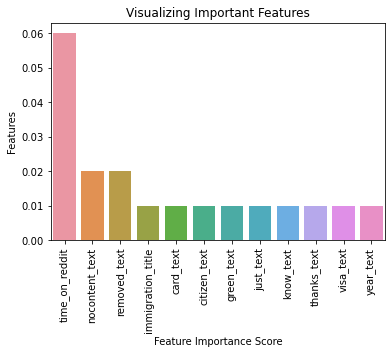

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=feature_importances_x, y=feature_importances_y)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.xticks(rotation=90)
plt.show();

The most importanrt features that affects whether a post is popular is time on reddit, the word "immigration" in the title, the words "card", "citizen", green", "just", "know", "thanks" and "visa". These features are pretty make a lot of sense, a posts time on reddit will increase engagement as more people are bound to see it. The words "green" and "card" most likely go hand in hand as people inqire about green cards. People in this subreddit usually post for other people who "know" the answer can share an answer. The words 'immigration", "visa" , and "citizen" are pretty popular general words around immigrants. And finally, showing gratitude by saying "thanks" also increases engagement. Our model also believes "nocontent_text" which is a place holder for popts with no content that I decided to keep to preserve titles and from removed posts. It's interesting to see that posts with no content and just a title can still be popular.I will now create a model without the removed_text and nocontent_text features to see if I can get a better model.

In [31]:
X = df_sample.drop(columns=['subreddit', 'date_posted', 'num_comments',
                            'popular', 'index', "nocontent_text", "removed_text"])
y = df_sample['popular']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)

print("X_train Size :",X_train.shape)
print("X_test Size :",X_test.shape)
print("y_train Size :",y_train.shape)
print("y_test Size :",y_test.shape)

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred))


X_train Size : (8000, 8362)
X_test Size : (2000, 8362)
y_train Size : (8000,)
y_test Size : (2000,)
Testing Accuracy: 0.803


It apprears removing those two features made our accuracy decrease slightly to 80%. In conclusion, our first random forest classifier model performed better and we can observe the freatures (time and words) that affect the popularity of a post.

# Model 2 - Logistic Regression 

In [32]:
X = df_sample.drop(columns=['subreddit', 'date_posted', 'num_comments', 'popular', 'index'])
y = df_sample['popular']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)

In [33]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred=log_reg.predict(X_test)
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred))

Testing Accuracy: 0.765


/Users/abiza/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This model only has an accuracy score of 76.5%.I will use random search to try diffrent combinations of hyperparameters so see if I can get a higher score.

In [34]:
log_reg = LogisticRegression(n_jobs=-1, random_state=42)
log_reg.fit(X_train, y_train)

y_pred=log_reg.predict(X_test)
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred))

/Users/abiza/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing Accuracy: 0.764


Over all, this model is performing significantly worse than the random forest model. So, I will stick to my random forest model for making infrences and recommendations.